In [5]:
import pandas as pd
import numpy as np
from ast import literal_eval

# for stop words
from nltk.corpus import stopwords

# for punctuations
import string

# for word frequency
from sklearn.feature_extraction.text import CountVectorizer

# for regular expression
import re

# for tokenization
from nltk.tokenize import TweetTokenizer

# for readability
from textatistic import Textatistic

# for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# for graph plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
precessed_train = pd.read_csv("Data/precessed_train.csv",
               usecols=['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'text_tokenized_nopunc', 
                        'POS_tagging', 'POS_tagging_flat', 'lemmatization', 'comment_text', 'noise_removed_text'],
                converters={'text_tokenized_nopunc': literal_eval, 'POS_tagging': literal_eval, 
                            'POS_tagging_flat': literal_eval, 'lemmatization': literal_eval})
print(precessed_train.shape)
precessed_train.head()

(159571, 13)


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_tokenized_nopunc,POS_tagging,POS_tagging_flat,lemmatization,comment_text,noise_removed_text
0,0000997932d777bf,0,0,0,0,0,0,"[explanation, why, the, edits, made, under, my...","[[(explanation, NN), (why, WRB), (the, DT), (e...","[(explanation, NN), (why, WRB), (the, DT), (ed...","[explanation, edits, made, username, hardcore,...",Explanation\r\nWhy the edits made under my use...,Explanation Why the edits made under my userna...
1,000103f0d9cfb60f,0,0,0,0,0,0,"[daww, he, matches, this, background, colour, ...","[[(d'aww, NN), (!, .)], [(he, PRP), (matches, ...","[(d'aww, NN), (!, .), (he, PRP), (matches, VBZ...","[d'aww, match, colour, i, am, seemingly, stuck...",D'aww! He matches this background colour I'm s...,D'aww! He matches this background colour I am ...
2,000113f07ec002fd,0,0,0,0,0,0,"[hey, man, i, am, really, not, trying, to, edi...","[[(hey, NN), (man, NN), (,, ,), (i, JJ), (am, ...","[(hey, NN), (man, NN), (,, ,), (i, JJ), (am, V...","[hey, man, i, am, really, not, trying, edit, w...","Hey man, I'm really not trying to edit war. It...","Hey man, I am really not trying to edit war. I..."
3,0001b41b1c6bb37e,0,0,0,0,0,0,"[more, i, cannot, make, any, real, suggestions...","[[("", IN), (more, JJR), (i, JJ), (cannot, NNS)...","[("", IN), (more, JJR), (i, JJ), (cannot, NNS),...","[more, i, cannot, make, real, suggestion, impr...","""\r\nMore\r\nI can't make any real suggestions...",""" More I cannot make any real suggestions on i..."
4,0001d958c54c6e35,0,0,0,0,0,0,"[you, sir, are, my, hero, any, chance, you, re...","[[(you, PRP), (,, ,), (sir, VB), (,, ,), (are,...","[(you, PRP), (,, ,), (sir, VB), (,, ,), (are, ...","[sir, are, hero, chance, remember, page, is]","You, sir, are my hero. Any chance you remember...","You, sir, are my hero. Any chance you remember..."


Feature engineering is done on the text data to extract useful information used for the later model building process.

## Create New Features from Text

In [8]:
# helper function to get sentence length in words
def get_sentence_stats(text_tag):
    length = []
    for sent in text_tag:
        word_list=[]
        for word in sent:
            if word[0] not in string.punctuation:
                word_list.append(word[0])
        length.append(len(word_list))
    # dealing with zero length case
    if len(length)==0:
        return [0, 0, 0, 0]
    else:
        return [np.mean(length), np.max(length), np.min(length), np.std(length)]

In [9]:
# helper function to get punctuations
def get_punctuations(sentences):
    count = 0
    for punc in string.punctuation:
        count += sentences.count(punc) 
    return count

In [10]:
# helper function to get unique words and repeated words
def get_unique_repeated(sentences):
    try:
        vec = CountVectorizer(ngram_range=(1, 1), stop_words=None)
        bow = vec.fit_transform([sentences])
        sum_of_words = bow.sum(axis=0)
        unigrams_freq = [(word, sum_of_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        unigrams_freq = pd.DataFrame(unigrams_freq,columns=['word','freq'])
        num_unqiue = sum(unigrams_freq[unigrams_freq.freq==1].freq)
        num_repeated = len(unigrams_freq[unigrams_freq.freq>1])
        return [num_unqiue, num_repeated]
    except:
        # dealing with the case when there is only stop words in the text
        try:
            sentences = sentences.replace(' ', '')
            vec = CountVectorizer(ngram_range=(1, 1), stop_words=None)
            bow = vec.fit_transform([sentences])
            sum_of_words = bow.sum(axis=0)
            unigrams_freq = [(word, sum_of_words[0, idx]) for word, idx in vec.vocabulary_.items()]
            unigrams_freq = pd.DataFrame(unigrams_freq,columns=['word','freq'])
            num_unqiue = sum(unigrams_freq[unigrams_freq.freq==1].freq)
            num_repeated = len(unigrams_freq[unigrams_freq.freq>1])
            return [num_unqiue, num_repeated]
        # dealing with empty text
        except:
            return [0, 0]

In [11]:
# helper function to get word tag counts
def get_word_tag_count(text_tag):
    noun_count = len([w for w in text_tag if w[1] in ('NN','NNP','NNPS','NNS')])
    adjective_count = len([w for w in text_tag if w[1] in ('JJ','JJR','JJS')])
    verb_count = len([w for w in text_tag if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
    return [noun_count, adjective_count, verb_count]

In [12]:
def get_uppercase(text):
    uppercase_count = sum(1 for c in text if c.isupper())
    tt = TweetTokenizer()
    text_tokenized = tt.tokenize(text)
    uppercase_words = sum(1 for word in text_tokenized if word.isupper())
    return [uppercase_count, uppercase_words]

In [13]:
# helper function to get the number of occurence of a regex
def count_regexp_occ(regexp="", text=None):
    return len(re.findall(regexp, text))

In [14]:
# helper function to get the readability score
def readability(text):
    # hyphenated word cannot have more than 100 characters
    text = text.replace('_', ' ')
    try:
        score = Textatistic(text).flesch_score
        return score
    except:
        # dealing with no sentence detected case
        try:
            text += '.'
            score = Textatistic(text).flesch_score
            return score
        # dealing with other cases
        except:
            return 0

In [15]:
# helper function to get the sentiment score
def sentiment(text):
    sentiments = SentimentIntensityAnalyzer()
    score = sentiments.polarity_scores(text)['compound']
    return score

In [16]:
bad_words = pd.read_csv('Data/frequent_bad_words.csv')
bad_words.head()

,Words,Category
0,dick,toxic
1,wanker,toxic
2,die,toxic
3,cock,toxic
4,gay,toxic


In [17]:
# helper function to get the number of bad words
def get_bad_words_count(text_lemmatized):
    counts = [] 
    for cat in bad_words.Category.unique():
        bad_word_list = list(bad_words[bad_words['Category']==cat].Words)
        count = sum(map(lambda x: text_lemmatized.count(x), bad_word_list))
        counts.append(count)
    return counts

In [19]:
# 40 mins for training set
def add_features(data):
    data2 = data.copy()

    # length of text
    print('creating length of text')
    data2['text_length'] = data2['comment_text'].apply(len)
    
    # sentence
    print('creating sentence features')
    # number of sentences
    data2['num_sentences'] = data2['POS_tagging'].apply(len)
    # sentence length in words
    sentence_stats = data2['POS_tagging'].apply(get_sentence_stats)
    # average length of sentences in words
    data2['average_length'] = sentence_stats.apply(lambda x: x[0])
    # maximum length of sentences in words
    data2['max_length'] = sentence_stats.apply(lambda x: x[1])
    # minimum length of sentences in words
    data2['min_length'] = sentence_stats.apply(lambda x: x[2])
    # standard deviation of sentences length in words
    data2['std_length'] = sentence_stats.apply(lambda x: x[3])
    
    # words
    print('creating word features')
    # number of words
    data2['num_words'] = data2['text_tokenized_nopunc'].apply(len)
    # number of words vs length
    data2['num_words_vs_length'] = np.where(data2['text_length']>0, data2['num_words']/data2['text_length'], 0)
    # length vs number of words
    data2['length_vs_num_words'] = np.where(data2['num_words']>0, data2['text_length']/data2['num_words'], 0)
    
    # stop words
    print('creating stop word features')
    stop_words = set(stopwords.words("english"))
    # number of stop words
    data2['num_stop_words'] = data2['text_tokenized_nopunc'].apply(lambda x: len(list(word for word in x if word in stop_words)))
    # number of stop words vs length
    data2['stop_words_vs_length'] = np.where(data2['text_length']>0, data2['num_stop_words']/data2['text_length'], 0)
    # number of stop words vs words
    data2['stop_words_vs_words'] = np.where(data2['num_words']>0, data2['num_stop_words']/data2['num_words'], 0)
    
    # exclamation marks
    print('creating exclamation mark features')
    # number of exclamation marks
    data2['num_exclamation_marks'] = data2['noise_removed_text'].apply(lambda x: x.count('!'))
    # number of exclamation marks vs length
    data2['exclamation_marks_vs_length'] = np.where(data2['text_length']>0, data2['num_exclamation_marks']/data2['text_length'], 0)
    # number of exclamation marks vs words
    data2['exclamation_marks_vs_words'] = np.where(data2['num_words']>0, data2['num_exclamation_marks']/data2['num_words'], 0)
    
    # question marks
    print('creating question mark features')
    # number of question marks
    data2['num_question_marks'] = data2['noise_removed_text'].apply(lambda x: x.count('?'))
    # number of question marks vs length
    data2['question_marks_vs_length'] = np.where(data2['text_length']>0, data2['num_question_marks']/data2['text_length'], 0)
    # number of question marks vs words
    data2['question_marks_vs_words'] = np.where(data2['num_words']>0, data2['num_question_marks']/data2['num_words'], 0)
    
    # punctuations
    print('creating punctuations features')
    # number of punctuations
    data2['num_punctuations'] = data2['noise_removed_text'].apply(get_punctuations)
    # number of punctuations vs length
    data2['punctuations_vs_length'] = np.where(data2['text_length']>0, data2['num_punctuations']/data2['text_length'], 0)
    # number of punctuations vs words
    data2['punctuations_vs_words'] = np.where(data2['num_words']>0, data2['num_punctuations']/data2['num_words'], 0)
    
    # unique words and repeated words
    print('creating unique and repeated word features')
    unique_repeated = data2['comment_text'].apply(get_unique_repeated)
    # number of unique words
    data2['num_unique_words'] = unique_repeated.apply(lambda x: x[0])
    # number of unique words vs length
    data2['unique_words_vs_length'] = np.where(data2['text_length']>0, data2['num_unique_words']/data2['text_length'], 0)
    # number of unique words vs words
    data2['unique_words_vs_words'] = np.where(data2['num_words']>0, data2['num_unique_words']/data2['num_words'], 0)
    # number of repeated words
    data2['num_repeated_words'] = unique_repeated.apply(lambda x: x[1])
    # number of repeated words vs length
    data2['repeated_words_vs_length'] = np.where(data2['text_length']>0, data2['num_repeated_words']/data2['text_length'], 0)
    # number of repeated words vs words
    data2['repeated_words_vs_words'] = np.where(data2['num_words']>0, data2['num_repeated_words']/data2['num_words'], 0)

    # word tag
    print('creating word tag features')
    word_tag = data2['POS_tagging_flat'].apply(get_word_tag_count)
    # number of nouns
    data2['num_nouns'] = word_tag.apply(lambda x: x[0])
    # number of nouns vs length
    data2['nouns_vs_length'] = np.where(data2['text_length']>0, data2['num_nouns']/data2['text_length'], 0)
    # number of nouns vs words
    data2['nouns_vs_words'] = np.where(data2['num_words']>0, data2['num_nouns']/data2['num_words'], 0)
    # number of adjectives
    data2['num_adjectives'] = word_tag.apply(lambda x: x[1])
    # number of adjectives vs length
    data2['adjectives_vs_length'] = np.where(data2['text_length']>0, data2['num_adjectives']/data2['text_length'], 0)
    # number of adjectives vs words
    data2['adjectives_vs_words'] = np.where(data2['num_words']>0, data2['num_adjectives']/data2['num_words'], 0)
    # number of verbs
    data2['num_verbs'] = word_tag.apply(lambda x: x[2])
    # number of verbs vs length
    data2['verbs_vs_length'] = np.where(data2['text_length']>0, data2['num_verbs']/data2['text_length'], 0)
    # number of verbs vs words
    data2['verbs_vs_words'] = np.where(data2['num_words']>0, data2['num_verbs']/data2['num_words'], 0)
    
    # uppercase
    print('creating uppercase features')
    uppercase = data2['noise_removed_text'].apply(get_uppercase)
    # number of capitals
    data2['num_uppercase'] = uppercase.apply(lambda x: x[0])
    # number of capitals vs length
    data2['uppercase_vs_length'] = np.where(data2['text_length']>0, data2['num_uppercase']/data2['text_length'], 0)
    # number of capitals vs words
    data2['uppercase_vs_words'] = np.where(data2['num_words']>0, data2['num_uppercase']/data2['num_words'], 0)
    # number of words that entirely in upper case
    data2['num_uppercase_words'] = uppercase.apply(lambda x: x[1])
    # number of uppercase words vs length
    data2['uppercase_words_vs_length'] = np.where(data2['text_length']>0, data2['num_uppercase_words']/data2['text_length'], 0)
    # number of uppercase words vs words
    data2['uppercase_words_vs_words'] = np.where(data2['num_words']>0, data2['num_uppercase_words']/data2['num_words'], 0)

    # date and time
    print('creating date and time features')
    # number of timestamp
    data2["num_timestamp"] = data2["comment_text"].apply(lambda x: count_regexp_occ(r"\d{2}:\d{2}", x))
    # number of dates (long form)
    data2["num_date_long"] = data2["comment_text"].apply(lambda x: count_regexp_occ(r"\D\d{2}:\d{2}, \d{1,2} \w+ \d{4}", x))
    # number of dates (short form)
    data2["num_date_short"] = data2["comment_text"].apply(lambda x: count_regexp_occ(r"\D\d{1,2} \w+ \d{4}", x))

    # IP address, URL, mail address
    print('creating special sequence features')
    # number of IP address
    data2["num_ip"] = data2["comment_text"].apply(lambda x: count_regexp_occ(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', x))
    # number of http links
    data2["num_http"] = data2["comment_text"].apply(lambda x: count_regexp_occ(r"http[s]{0,1}://\S+", x))
    # number of mail address
    data2["num_mail"] = data2["comment_text"].apply(lambda x: count_regexp_occ(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', x))
    
    # readability, sentiment, profanity
    print('creating text analysis features')
    # readability score -- time consuming
    # data2["readability"] = data2["noise_removed_text"].apply(readability)
    # sentiment analysis
    data2["sentiment"] = data2["noise_removed_text"].apply(sentiment)
    # profanity check
    
    # bad words
    print('creating bad word features')
    bad_words_count = data2["lemmatization"].apply(get_bad_words_count)
    # number of bad words of toxic comments
    data2['num_bad_toxic'] = bad_words_count.apply(lambda x: x[0])
    # number of bad words of toxic comments vs length
    data2['bad_toxic_vs_length'] = np.where(data2['text_length']>0, data2['num_bad_toxic']/data2['text_length'], 0)
    # number of bad words of toxic comments vs words
    data2['bad_toxic_vs_words'] = np.where(data2['num_words']>0, data2['num_bad_toxic']/data2['num_words'], 0)
    # number of bad words of severe_toxic comments
    data2['num_bad_severe_toxic'] = bad_words_count.apply(lambda x: x[1])
    # number of bad words of severe_toxic comments vs length
    data2['bad_severe_toxic_vs_length'] = np.where(data2['text_length']>0, data2['num_bad_severe_toxic']/data2['text_length'], 0)
    # number of bad words of severe_toxic comments vs words
    data2['bad_severe_toxic_vs_words'] = np.where(data2['num_words']>0, data2['num_bad_severe_toxic']/data2['num_words'], 0)
    # number of bad words of obscene comments
    data2['num_bad_obscene'] = bad_words_count.apply(lambda x: x[2])
    # number of bad words of obscene comments vs length
    data2['bad_obscene_vs_length'] = np.where(data2['text_length']>0, data2['num_bad_obscene']/data2['text_length'], 0)
    # number of bad words of obscene comments vs words
    data2['bad_obscene_vs_words'] = np.where(data2['num_words']>0, data2['num_bad_obscene']/data2['num_words'], 0)
    # number of bad words of threat comments
    data2['num_bad_threat'] = bad_words_count.apply(lambda x: x[3])
    # number of bad words of threat comments vs length
    data2['bad_threat_vs_length'] = np.where(data2['text_length']>0, data2['num_bad_threat']/data2['text_length'], 0)
    # number of bad words of threat comments vs words
    data2['bad_threat_vs_words'] = np.where(data2['num_words']>0, data2['num_bad_threat']/data2['num_words'], 0)
    # number of bad words of insult comments
    data2['num_bad_insult'] = bad_words_count.apply(lambda x: x[4])
    # number of bad words of insult comments vs length
    data2['bad_insult_vs_length'] = np.where(data2['text_length']>0, data2['num_bad_insult']/data2['text_length'], 0)
    # number of bad words of insult comments vs words
    data2['bad_insult_vs_words'] = np.where(data2['num_words']>0, data2['num_bad_insult']/data2['num_words'], 0)
    # number of bad words of identity_hate comments
    data2['num_bad_identity_hate'] = bad_words_count.apply(lambda x: x[5])
    # number of bad words of identity_hate comments vs length
    data2['bad_identity_hate_vs_length'] = np.where(data2['text_length']>0, data2['num_bad_identity_hate']/data2['text_length'], 0)
    # number of bad words of identity_hate comments vs words
    data2['bad_identity_hate_vs_words'] = np.where(data2['num_words']>0, data2['num_bad_identity_hate']/data2['num_words'], 0)
    
    return data2

In [20]:
featured_train = add_features(precessed_train)

creating length of text
creating sentence features
creating word features
creating stop word features
creating exclamation mark features
creating question mark features
creating punctuations features
creating unique and repeated word features
creating word tag features
creating uppercase features
creating date and time features
creating special sequence features
creating text analysis features
creating bad word features


In [21]:
featured_train.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_tokenized_nopunc,POS_tagging,POS_tagging_flat,...,bad_obscene_vs_words,num_bad_threat,bad_threat_vs_length,bad_threat_vs_words,num_bad_insult,bad_insult_vs_length,bad_insult_vs_words,num_bad_identity_hate,bad_identity_hate_vs_length,bad_identity_hate_vs_words
0,0000997932d777bf,0,0,0,0,0,0,"[explanation, why, the, edits, made, under, my...","[[(explanation, NN), (why, WRB), (the, DT), (e...","[(explanation, NN), (why, WRB), (the, DT), (ed...",...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,000103f0d9cfb60f,0,0,0,0,0,0,"[daww, he, matches, this, background, colour, ...","[[(d'aww, NN), (!, .)], [(he, PRP), (matches, ...","[(d'aww, NN), (!, .), (he, PRP), (matches, VBZ...",...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
2,000113f07ec002fd,0,0,0,0,0,0,"[hey, man, i, am, really, not, trying, to, edi...","[[(hey, NN), (man, NN), (,, ,), (i, JJ), (am, ...","[(hey, NN), (man, NN), (,, ,), (i, JJ), (am, V...",...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
3,0001b41b1c6bb37e,0,0,0,0,0,0,"[more, i, cannot, make, any, real, suggestions...","[[("", IN), (more, JJR), (i, JJ), (cannot, NNS)...","[("", IN), (more, JJR), (i, JJ), (cannot, NNS),...",...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
4,0001d958c54c6e35,0,0,0,0,0,0,"[you, sir, are, my, hero, any, chance, you, re...","[[(you, PRP), (,, ,), (sir, VB), (,, ,), (are,...","[(you, PRP), (,, ,), (sir, VB), (,, ,), (are, ...",...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0


## Store the featured data

In [22]:
featured_train.to_csv('Data/featured_train.csv', index=False)

## Curseword Detection

Refer to https://github.com/vzhou842/profanity-check to use as an indicator for curseword

In [ ]:
featured_df['curseWord'] =  featured_df['clean_text'].apply(lambda x: predict([x])[0])

In [86]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_length,words,text_tokenized
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,45,"[Explanation, Why, the, edits, made, under, my..."
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,17,"[D'aww, !, He, matches, this, background, colo..."
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,42,"[Hey, man, ,, I'm, really, not, trying, to, ed..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,111,"["", More, I, can't, make, any, real, suggestio..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,13,"[You, ,, sir, ,, are, my, hero, ., Any, chance..."


## Selection

In [125]:
featured_train.columns

Index(['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate', 'text_tokenized_nopunc', 'POS_tagging',
       'POS_tagging_flat', 'lemmatization', 'comment_text',
       'noise_removed_text', 'text_length', 'num_sentences', 'average_length',
       'max_length', 'min_length', 'std_length', 'num_words',
       'num_words_vs_length', 'length_vs_num_words', 'num_stop_words',
       'stop_words_vs_length', 'stop_words_vs_words', 'num_exclamation_marks',
       'exclamation_marks_vs_length', 'exclamation_marks_vs_words',
       'num_question_marks', 'question_marks_vs_length',
       'question_marks_vs_words', 'num_punctuations', 'punctuations_vs_length',
       'punctuations_vs_words', 'num_unique_words', 'unique_words_vs_length',
       'unique_words_vs_words', 'num_repeated_words',
       'repeated_words_vs_length', 'repeated_words_vs_words', 'num_nouns',
       'nouns_vs_length', 'nouns_vs_words', 'num_adjectives',
       'adjectives_vs_length', 'adjectives

In [126]:
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
features = ('text_length', 'num_sentences', 'average_length',
       'max_length', 'min_length', 'std_length', 'num_words',
       'num_words_vs_length', 'length_vs_num_words', 'num_stop_words',
       'stop_words_vs_length', 'stop_words_vs_words', 'num_exclamation_marks',
       'exclamation_marks_vs_length', 'exclamation_marks_vs_words',
       'num_question_marks', 'question_marks_vs_length',
       'question_marks_vs_words', 'num_punctuations', 'punctuations_vs_length',
       'punctuations_vs_words', 'num_unique_words', 'unique_words_vs_length',
       'unique_words_vs_words', 'num_repeated_words',
       'repeated_words_vs_length', 'repeated_words_vs_words', 'num_nouns',
       'nouns_vs_length', 'nouns_vs_words', 'num_adjectives',
       'adjectives_vs_length', 'adjectives_vs_words', 'num_verbs',
       'verbs_vs_length', 'verbs_vs_words', 'num_uppercase',
       'uppercase_vs_length', 'uppercase_vs_words', 'num_uppercase_words',
       'uppercase_words_vs_length', 'uppercase_words_vs_words',
       'num_timestamp', 'num_date_long', 'num_date_short', 'num_ip',
       'num_http', 'num_mail', 'readability', 'sentiment', 'num_bad_toxic',
       'bad_toxic_vs_length', 'bad_toxic_vs_words', 'num_bad_severe_toxic',
       'bad_severe_toxic_vs_length', 'bad_severe_toxic_vs_words',
       'num_bad_obscene', 'bad_obscene_vs_length', 'bad_obscene_vs_words',
       'num_bad_threat', 'bad_threat_vs_length', 'bad_threat_vs_words',
       'num_bad_insult', 'bad_insult_vs_length', 'bad_insult_vs_words',
       'num_bad_identity_hate', 'bad_identity_hate_vs_length',
       'bad_identity_hate_vs_words'
           )
featured_train['none'] = 1 - featured_train[LABELS].max(axis=1)

In [127]:
columns = LABELS + ['none']
rows = [{c:featured_train[f].corr(featured_train[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)

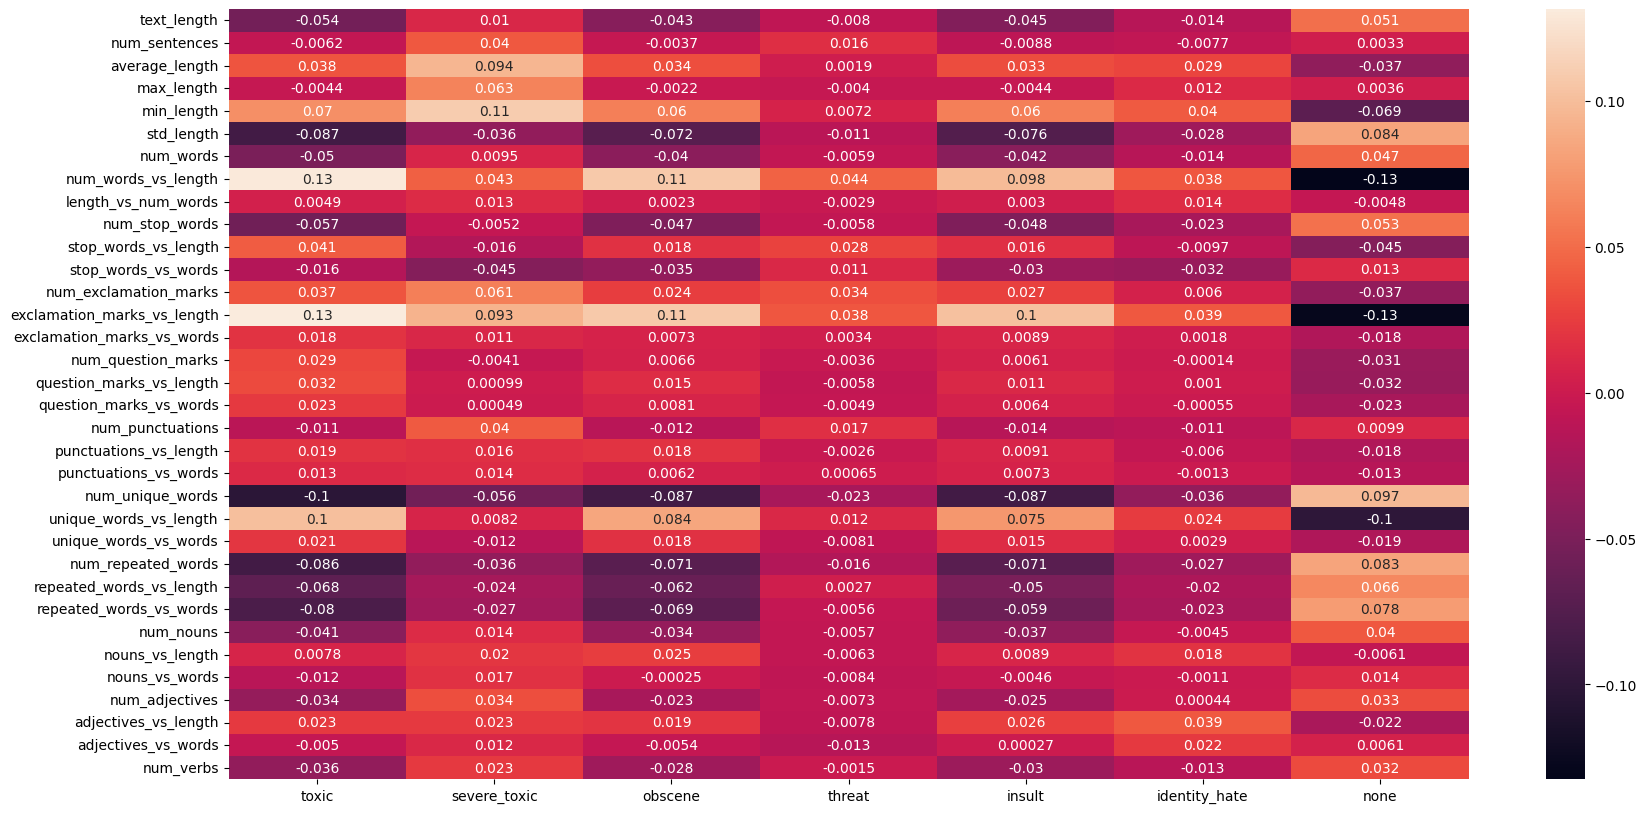

In [136]:
# first 34 features
plt.figure(figsize = (20,10))
sns.heatmap(train_correlations[:34], annot=True)
plt.show()

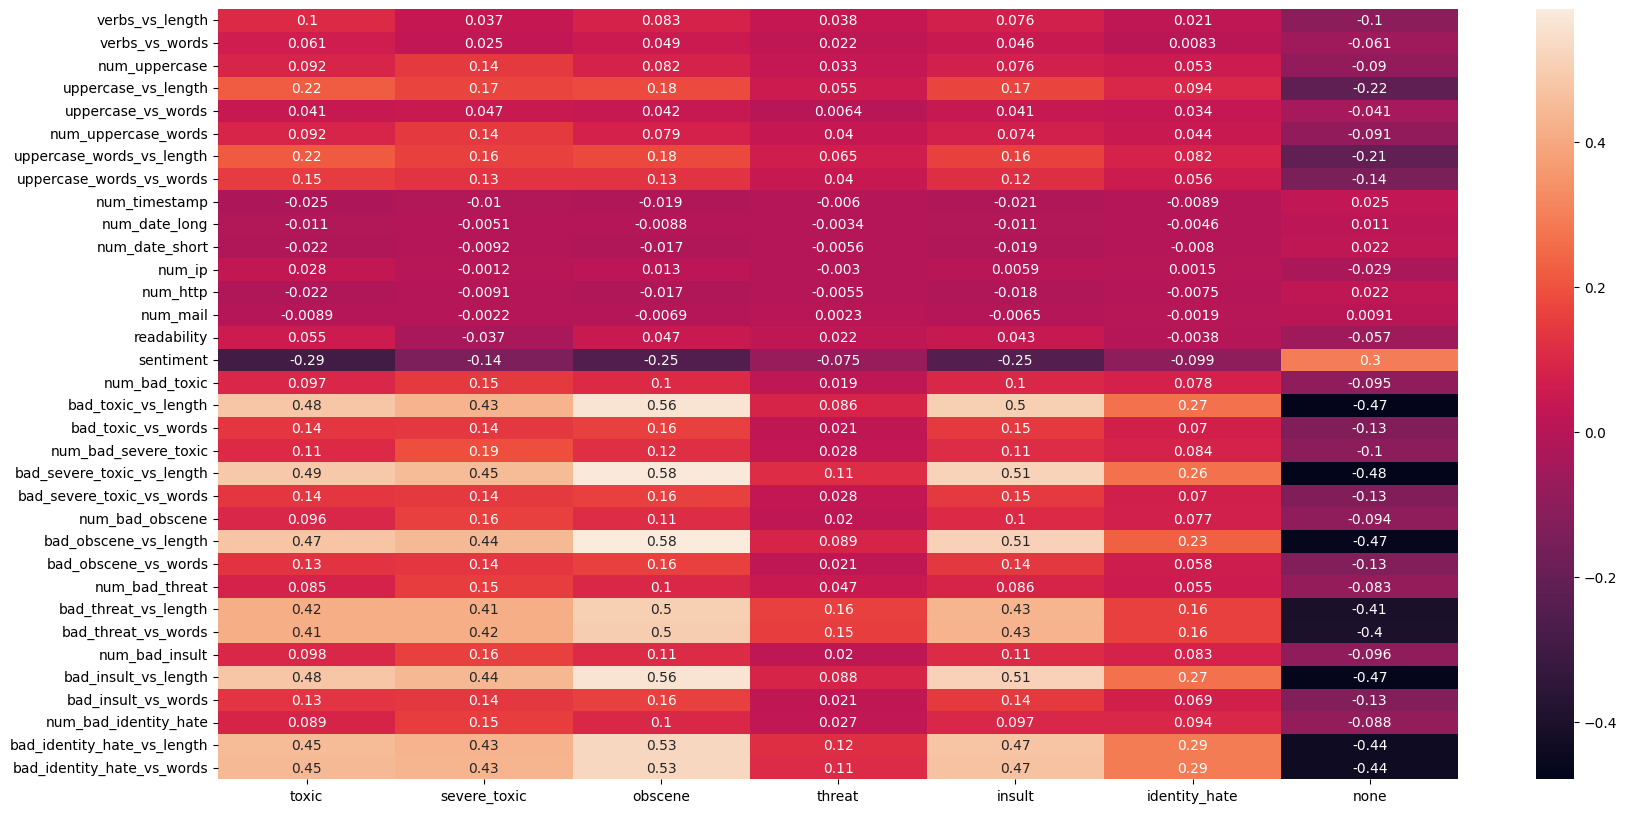

In [137]:
# the rest features
plt.figure(figsize = (20,10))
sns.heatmap(train_correlations[34:], annot=True)
plt.show()

In [156]:
# set the threshold to be 0.1, meaning that the absolute value of correlation should at least 0.1 for at least one category
masking = list(map(lambda x: abs(max(train_correlations.iloc[x], key=abs))>0.1, range(len(train_correlations))))

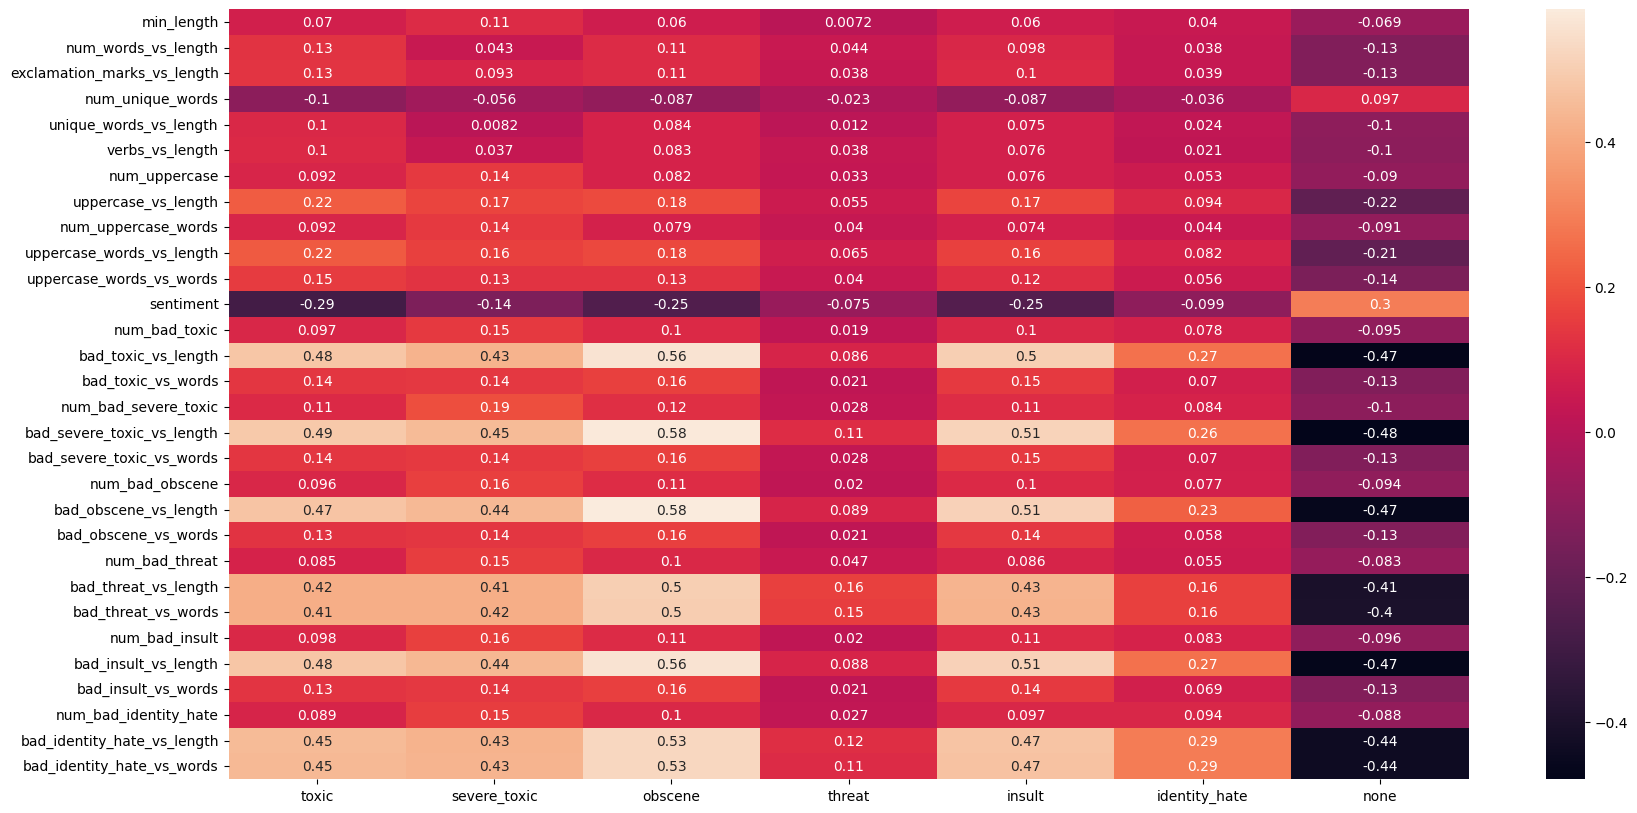

In [157]:
# potentially useful features
plt.figure(figsize = (20,10))
sns.heatmap(train_correlations[masking], annot=True)
plt.show()